In [96]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from mlflow import MlflowClient 
from mlflow.models import infer_signature
import mlflow
plt.style.use('fivethirtyeight')

In [74]:
ab_df = pd.read_csv('../../data/interim/absences_per_day.csv', sep=',')
#only keep columns index and count 
ab_df = ab_df[['index', 'count']]
#rename index to date
ab_df = ab_df.rename(columns={'index': 'date'})
ab_df['date'] = pd.to_datetime(ab_df['date'])
# drop data older than 2023-03-01
ab_df = ab_df[ab_df['date'] < '2023-03-01']

ab_df

,date,count
0,2014-03-17,3
1,2014-03-18,4
2,2014-03-19,4
3,2014-03-20,4
4,2014-03-21,4
...,...,...
3266,2023-02-24,496
3267,2023-02-25,541
3268,2023-02-26,347
3269,2023-02-27,430


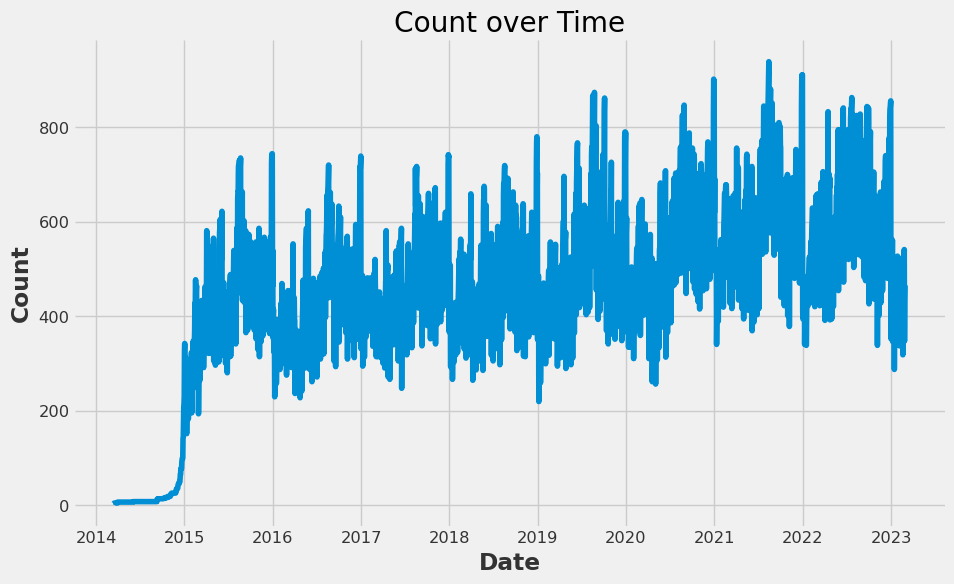

In [75]:
plt.figure(figsize=(10, 6))
plt.plot(ab_df['date'], ab_df['count'], marker='o', linestyle='-', markersize=1)
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Count over Time')
plt.grid(True)
plt.show()

In [76]:
split_date = '01-Jul-2022'
ab_train = ab_df.loc[ab_df['date'] <= split_date].copy()
ab_test = ab_df.loc[ab_df['date'] > split_date].copy()

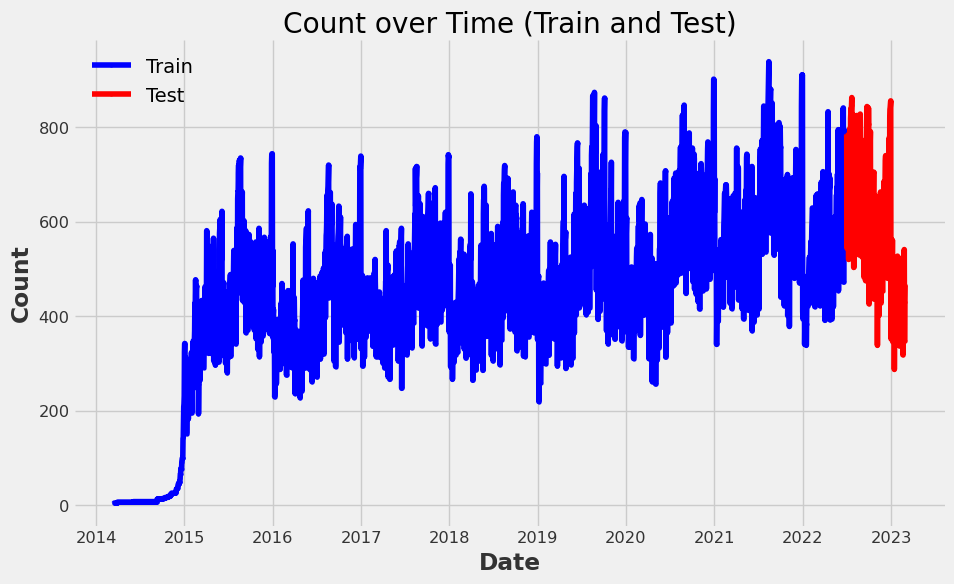

In [77]:
plt.figure(figsize=(10, 6))
plt.plot(ab_train['date'], ab_train['count'], marker='o', linestyle='-', markersize=2, color='blue', label='Train')

# Plot the test set with another color (e.g., red)
plt.plot(ab_test['date'], ab_test['count'], marker='o', linestyle='-', markersize=2, color='red', label='Test')

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Count over Time (Train and Test)')
plt.legend()  # Add legend to distinguish between Train and Test
plt.grid(True)
plt.show()

In [78]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df['date']
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [79]:
X_train, y_train = create_features(ab_train, label='count')
X_test, y_test = create_features(ab_test, label='count')

C:\Users\jakob\AppData\Local\Temp\ipykernel_7900\1007601217.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
C:\Users\jakob\AppData\Local\Temp\ipykernel_7900\1007601217.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


In [80]:
mlflow.xgboost.autolog()

In [81]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train
       
y_pred = reg.predict(X_test)


2023/08/02 16:54:35 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2b5a3159d77f4cfa8813ca3192631fa2', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
c:\Users\jakob\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
2023/08/02 16:54:36 ERROR mlflow.xgboost: Failed to log feature importance plot. XGBoost autologging will ignore the failure and continue. Exception: 
Traceback (most recent call last):
  File "c:\Users\jakob\AppData\Local\Programs\Python\Python39\lib\site-packages\mlflow\xgboost\__init__.py", line 665, in train_impl
    log_feature_importance_plot(features, importance, imp_type)
  File "c:\Users\jakob\AppData\Local\Programs\Python\Python39\lib

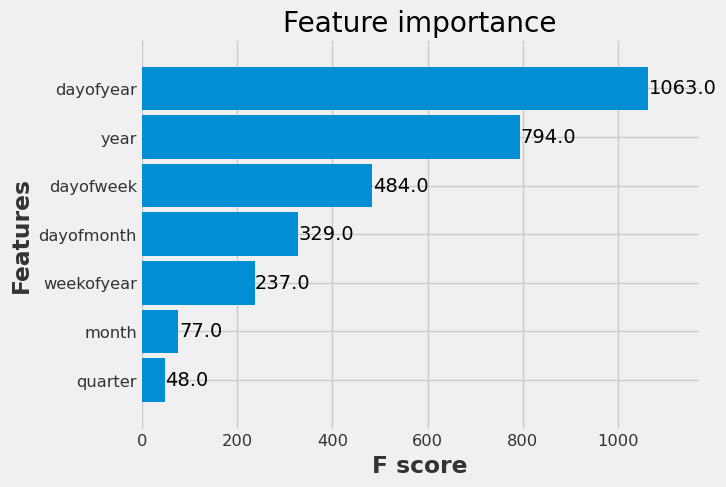

In [82]:
_ = plot_importance(reg, height=0.9)


In [83]:
ab_test['absence_Prediction'] = reg.predict(X_test)
count_all = pd.concat([ab_test, ab_train], sort=False)


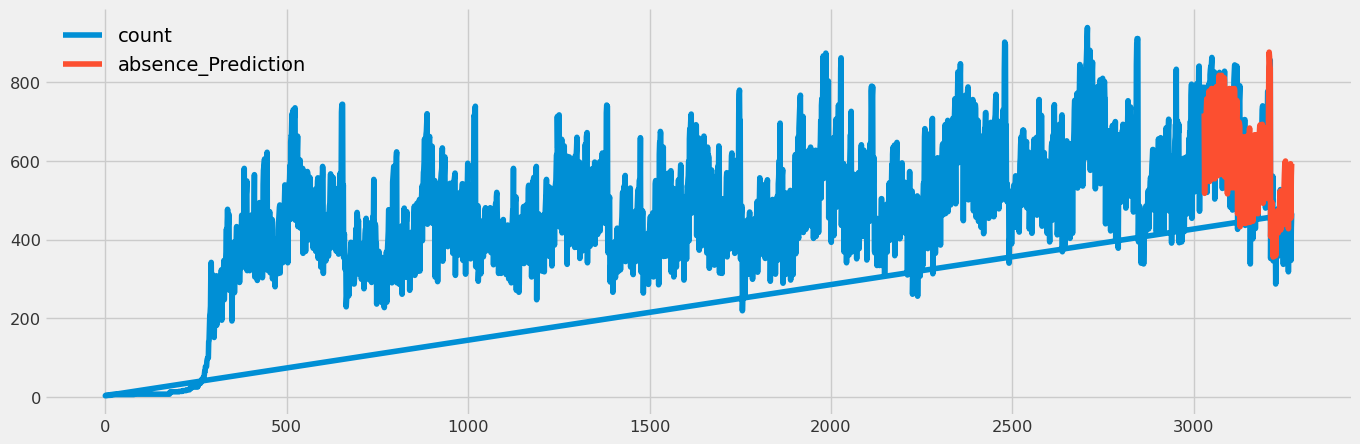

In [84]:
_ = count_all[['count','absence_Prediction']].plot(figsize=(15, 5))


In [94]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

In [97]:
mlflow.set_tracking_uri('./mlruns')
mlflow.set_experiment('singlets')
experiment = mlflow.get_experiment_by_name('singlets')
client = MlflowClient()

run = client.create_run(experiment.experiment_id)

with mlflow.start_run(run_id=run.info.run_id) as run:

    (rmse, mae, r2) = eval_metrics(y_test, y_pred)
    
    mlflow.xgboost.log_model(reg, 'model')

In [89]:
# Calculate absolute percentage errors
ape = np.abs((y_test - y_pred) / y_test) * 100

# Calculate MAPE
mape = np.mean(ape)
print(f"MAPE: {mape:.2f}%")


MAPE: 8.66%


In [90]:
y_pred

array([720.45123, 517.5051 , 617.82367, 637.7706 , 679.1645 , 707.8974 ,
       733.0505 , 757.949  , 556.77386, 706.347  , 712.7882 , 728.8919 ,
       752.1097 , 777.2627 , 770.1785 , 547.5664 , 697.1395 , 712.7882 ,
       735.7103 , 758.9281 , 784.0811 , 776.99695, 554.3848 , 703.95795,
       719.6066 , 735.7103 , 758.9281 , 784.0811 , 776.99695, 554.3848 ,
       683.83167, 699.48035, 740.9245 , 764.1423 , 789.2953 , 782.2111 ,
       561.83826, 729.3171 , 759.7272 , 769.16266, 792.38043, 817.5335 ,
       810.44934, 565.1141 , 752.04016, 759.7272 , 769.16266, 792.38043,
       817.5335 , 810.44934, 565.1141 , 745.94995, 753.63696, 763.07245,
       786.2902 , 811.4433 , 804.35913, 559.02386, 745.94995, 726.22   ,
       735.65546, 746.6507 , 771.8038 , 764.7196 , 516.1085 , 685.031  ,
       692.718  , 722.8578 , 758.8732 , 784.0263 , 776.94214, 531.6068 ,
       718.53296, 726.22   , 735.65546, 758.8732 , 784.0263 , 776.94214,
       531.6068 , 718.53296, 726.22   , 735.65546, 

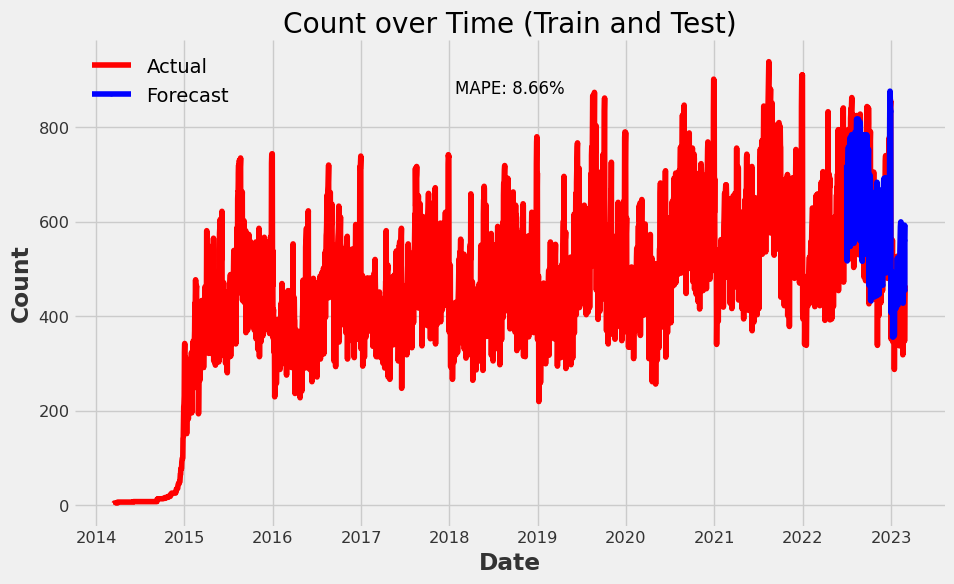

In [91]:
plt.figure(figsize=(10, 6))

# Plot the test set with another color (e.g., red)
plt.plot(ab_df['date'], ab_df['count'], marker='o', linestyle='-', markersize=1, color='red', label='Actual')
plt.plot(ab_test['date'], y_pred, marker='o', linestyle='-', markersize=2, color='blue', label='Forecast')

#plt.plot(ab_train['date'], ab_train['count'], marker='o', linestyle='-', markersize=2, color='red', label='Test')

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Count over Time (Train and Test)')
plt.legend()  # Add legend to distinguish between Train and Test
plt.grid(True)

plt.text(0.5, 0.9, f'MAPE: {mape:.2f}%', ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)

plt.show()

In [92]:
ab_df['date']

0      2014-03-17
1      2014-03-18
2      2014-03-19
3      2014-03-20
4      2014-03-21
          ...    
3266   2023-02-24
3267   2023-02-25
3268   2023-02-26
3269   2023-02-27
3270   2023-02-28
Name: date, Length: 3271, dtype: datetime64[ns]

In [93]:
result_df = pd.DataFrame({'date': ab_test['date'], 'count': y_pred})


result_df = pd.concat([pd.DataFrame({'date': ab_df['date'], 'count': ab_df['count']}), result_df])

# Sort the DataFrame by 'date'
result_df = result_df.sort_values(by='date')
result_df

,date,count
0,2014-03-17,3.000000
1,2014-03-18,4.000000
2,2014-03-19,4.000000
3,2014-03-20,4.000000
4,2014-03-21,4.000000
...,...,...
3268,2023-02-26,454.619873
3269,2023-02-27,561.095642
3269,2023-02-27,430.000000
3270,2023-02-28,465.000000
